In [142]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [143]:
import numpy as np
import pandas as pd

In [144]:
import datetime
import os

In [145]:
output_dir = os.path.join('.','output')

# Reflect Tables into SQLAlchemy ORM

In [146]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect
from sqlalchemy import func

In [147]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [148]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [149]:
# We can view all of the classes that automap found
tables = Base.classes.keys()

In [150]:
#Print all the tables and their columns
inspector = inspect(engine)
for i in tables:
    print(i)
    print("----")
    for j in inspector.get_columns(i):
        print(j['name'],j['type'])
    print("")

measurement
----
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
----
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [151]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [152]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [153]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
date_format = '%Y-%m-%d'
# Calculate the date 1 year ago from the last data point in the database
search_date = datetime.datetime.strptime(latest_date, date_format) - pd.DateOffset(years=1)
search_date = search_date.strftime(date_format)
# Perform a query to retrieve the data and precipitation scores
search = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date > search_date).statement
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql(search,session.bind,index_col='date').sort_index()
df = df.dropna()

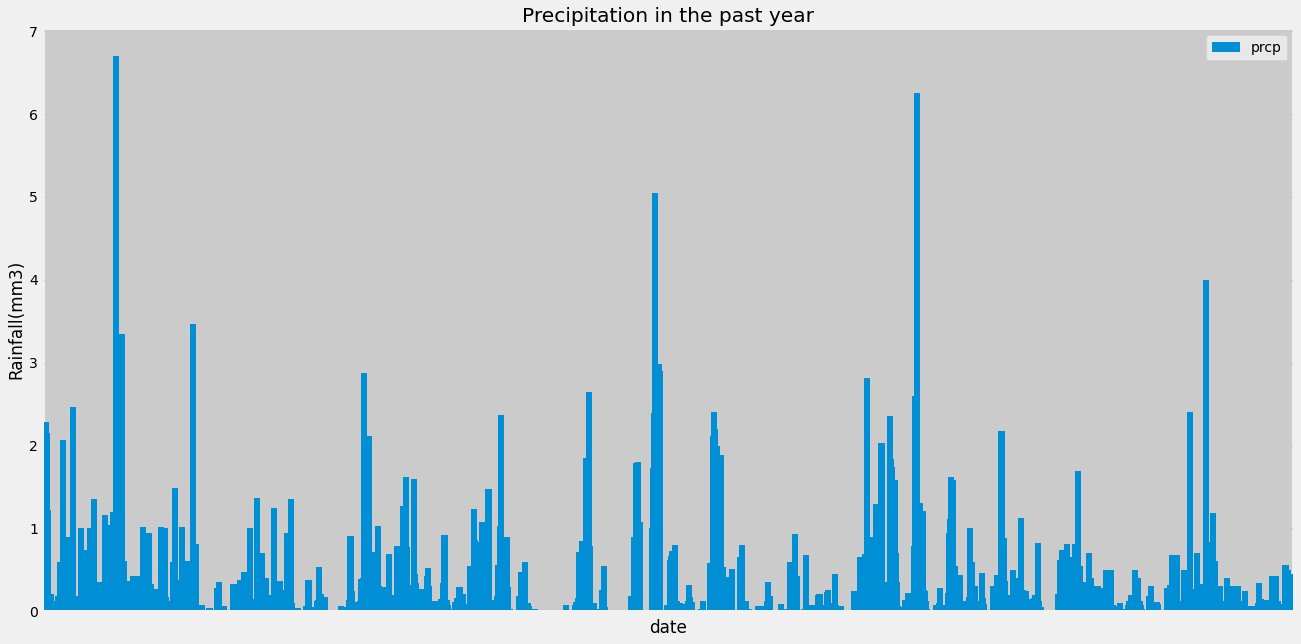

In [155]:
# Use Pandas Plotting with Matplotlib to plot the data
###CLEAN THIS GRAPH UP
graph = df.plot.bar(figsize=(20,10),width=10)
graph.set_xticklabels([])
plt.title("Precipitation in the past year")
plt.ylabel("Rainfall(mm3)")
plt.savefig(f"{output_dir}/precipitation_in_past_year")

In [156]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [157]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Station.station.distinct()).count()
print(f"There are {num_stations} stations")

There are 9 stations


In [158]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).order_by(func.count(Measurement.date).desc())
most_active = station_count.first()[0]
print(f"Most active station is {most_active}")
station_count.all()

Most active station is USC00519281


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [159]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_temps = session.query(Measurement.station, func.min(Measurement.tobs),func.avg(Measurement.tobs),func.max(Measurement.tobs)).filter(Measurement.station == most_active)
most_active_temps.all()

[('USC00519281', 54.0, 71.66378066378067, 85.0)]

In [160]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_stmt = session.query(Measurement.date,Measurement.tobs).filter(Measurement.date > search_date).filter(Measurement.station == most_active).statement
temp_df = pd.read_sql(temp_stmt,session.bind,index_col='date').sort_index().dropna()


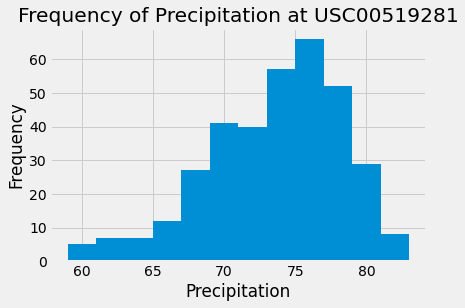

In [171]:
plt.hist(temp_df['tobs'],bins=12)
plt.ylabel("Frequency")
plt.xlabel("Precipitation")
plt.title(f"Frequency of Precipitation at {most_active}")
plt.tight_layout
plt.savefig(f"{output_dir}/frequency_of_prcp_{most_active}")

## Bonus Challenge Assignment

## 1 Temperature Analysis I

In [162]:
#Temp Analysis 1


In [163]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [164]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tstats = calc_temps(search_date, latest_date)[0]
tstats

(58.0, 74.59058295964125, 87.0)

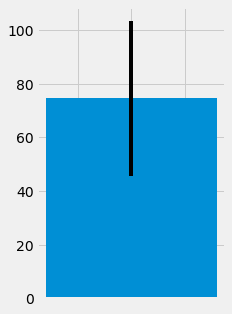

In [172]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x = [0]
y = [tstats[1]]
err = [tstats[2]-tstats[0]]
plt.figure(figsize=(3,5))
plt.bar(x,y,yerr=err)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

In [166]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
search_date
latest_date

query = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,func.sum(Measurement.prcp)).filter(Station.station == Measurement.station).group_by(Measurement.station).filter(Measurement.date > search_date).filter(Measurement.date < latest_date).order_by(func.sum(Measurement.prcp).desc()).all()
stations_df = pd.DataFrame(query, columns=['Station','Name','Lat','Long','Elevation','Precipication_sum'])
stations_df

,Station,Name,Lat,Long,Elevation,Precipication_sum
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,146.66
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,68.24
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,48.36
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,37.91
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,33.19
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,16.09
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,4.59


In [167]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [168]:
#My Trip
start_date = "2017-06-01"
end_date = "2017-06-08"
normals = []
date = []
start  = datetime.datetime.strptime(start_date, date_format)
end = datetime.datetime.strptime(end_date,date_format)
while start <= end:
    dform = datetime.datetime.strftime(start,'%m-%d')
    date.append(dform)
    normals.append(daily_normals(dform)[0])
    start = start + datetime.timedelta(days=1)

In [169]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
norm_df = pd.DataFrame(normals,columns=['tmin','tavg','tmax'])
norm_df['date'] = date
norm_df.set_index('date')

,tmin,tavg,tmax
date,,,
06-01,64.0,74.614035,81.0
06-02,65.0,74.400000,81.0
06-03,65.0,74.034483,80.0
06-04,65.0,73.818182,81.0
06-05,68.0,74.854545,81.0
06-06,70.0,75.175439,80.0
06-07,68.0,75.071429,81.0
06-08,70.0,75.586207,81.0


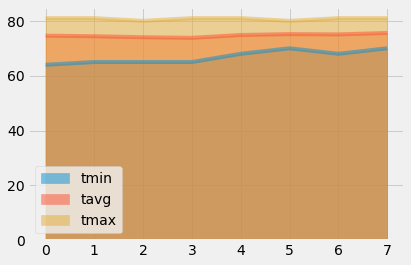

In [170]:
# Plot the daily normals as an area plot with `stacked=False`
norm_df.plot.area(stacked=False)